# **Presentación del Caso House Pricing**

En el presente ejemplo comenzaremos con un dataset **público** utilizado para la **predicción del precio de venta de casas**. Este dataset está basado en un vecindario ubicado en Ames, Iowa, Estados Unidos.

Se ha recopilado un total de 79 variables predictoras de tipo categórica y numérico, sin embargo la variable objetivo (target) es el **precio de venta** cuyo tipo de dato es **numérico**.

Por ello vamos a utilizar **modelos de regresión** para resolver este problema.

Puedes acceder a la competencia original en la web [aquí](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

# **Comprensión de los datos**

In [0]:
import pandas as pd
train=pd.read_csv('https://raw.githubusercontent.com/HackSpacePeru/Datasets_intro_Data_Science/master/House_pricing/train.csv')
train.set_index('Id', inplace=True)
test = pd.read_csv('https://raw.githubusercontent.com/HackSpacePeru/Datasets_intro_Data_Science/master/House_pricing/test.csv')
test.set_index('Id', inplace=True)


In [33]:
train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [34]:
test.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


Verificamos el total de filas y las columnas

In [35]:
train.shape, test.shape

((1460, 80), (1459, 79))

Comprobamos efectivamente que contamos con **79 variables predictoras**. Recuerda que **train** cuenta con **una columna adicional: SalesPrice**

Adicionalmente podemos verificar el **tipo de dato** de cada una de las variables: object, int o float

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

##Matriz de Correlación


A través del método **corr()** podemos obtener la correlación de las variables de un dataset

Para visualizar las correlaciones usamos seaborn a través del método **heatmap**

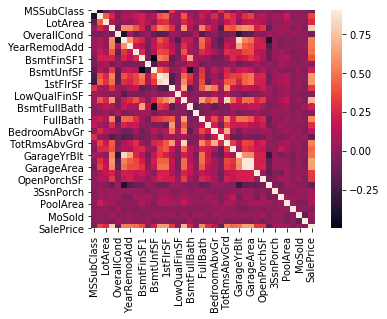

In [37]:
import seaborn as sns
corrmat = train.corr()
sns.heatmap(corrmat, vmax=0.9, square=True)

Comprobamos efectivamente que no se visualiza una **correlación directa** entre variables:

*   Una correlación de 1 (blanco) se visualiza entre una variable y sí misma
*   Todas las demás variables permanecen con una correlación por debajo de 0.5.



# **Preprocesamiento de los datos**

##Preprocesamiento de nulos o vacíos

In [0]:
import missingno as ms

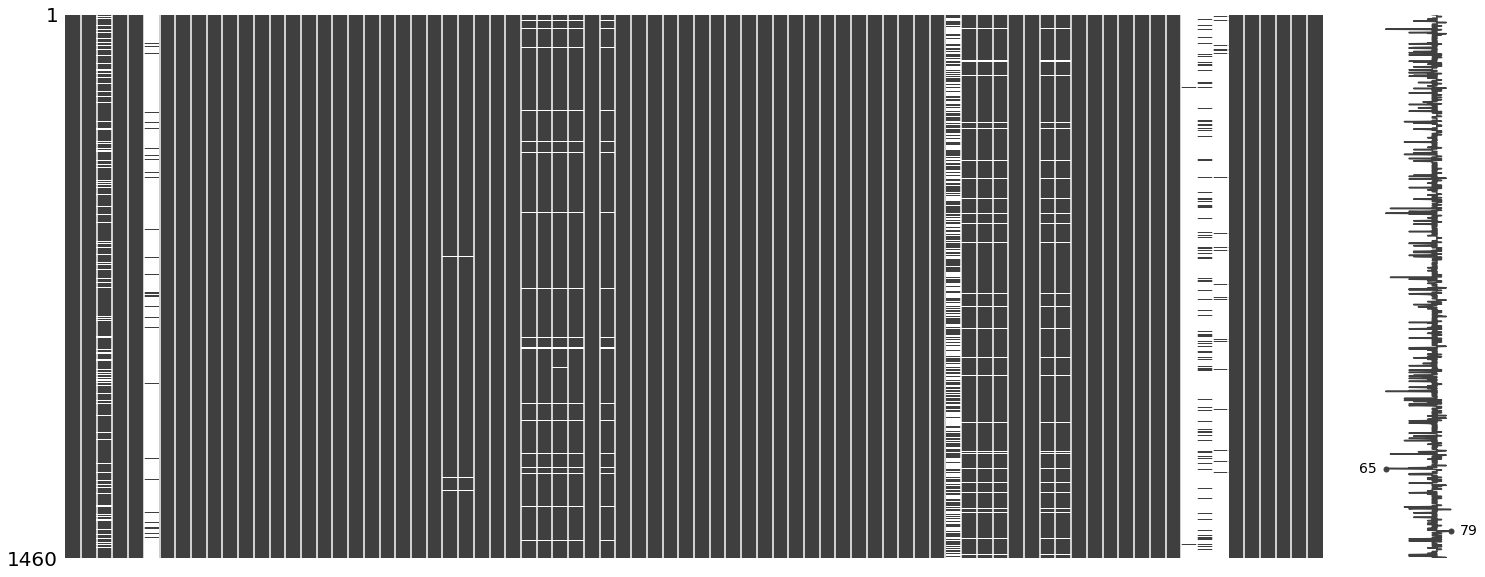

In [39]:
ms.matrix(train)

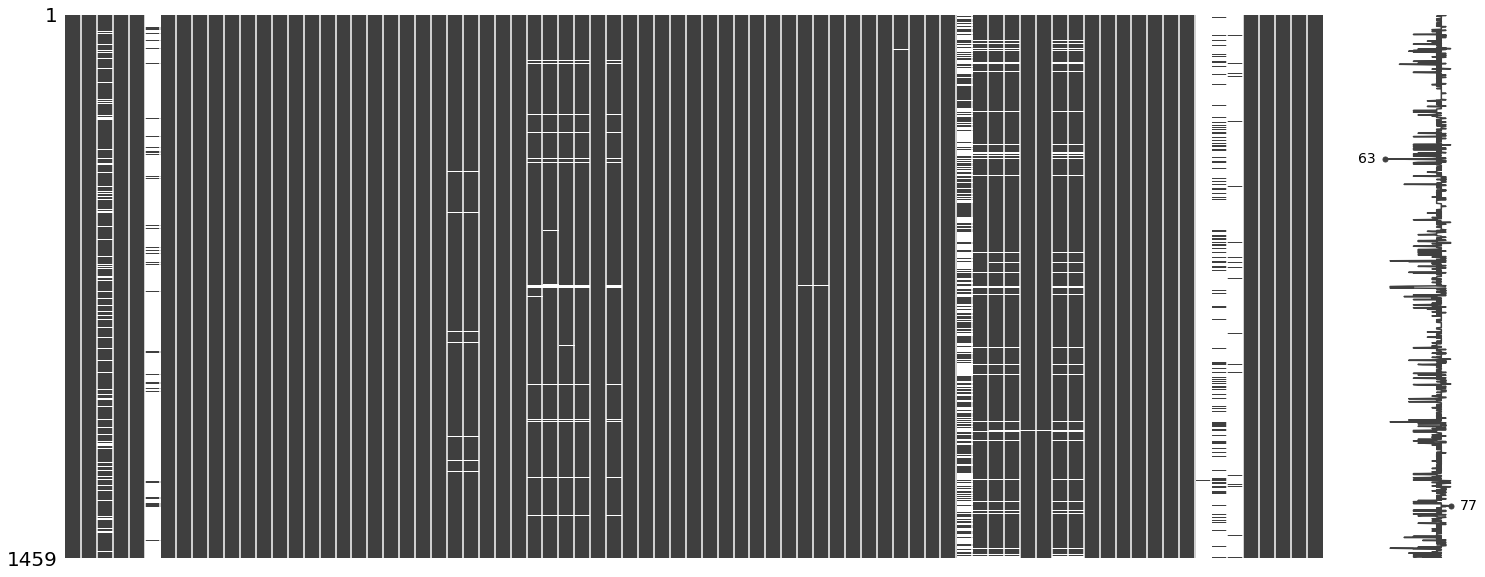

In [40]:
ms.matrix(test)

Reemplazamos los datos faltantes según el tipo de dato en cada columna:

1.   Si el tipo de dato es **numérico** (int64, float64) procedemos a reemplazarlo por la **media**
2.   Si el tipo de dato **no es numérico** (object) procedemos a reemplazarlo por la **moda**



In [0]:
columnas_object_nulos = [col for col in test.columns if ((train[col].dtype =='object')|(test[col].dtype == 'object')&((train[col].isna().any()|(test[col].isna().any()))))]

In [0]:
def reemplazando_non_nans(df, lista_cols_obj_nulos):
    for col in lista_cols_obj_nulos:
        df[col].fillna(train[col].mode()[0],inplace=True)

In [0]:
reemplazando_non_nans(train,columnas_object_nulos)
reemplazando_non_nans(test,columnas_object_nulos)

In [0]:
lista_nulos_numericos = [col for col in test.columns if (test[col].isna().any())]

In [0]:
for col in lista_nulos_numericos:
    train[col].fillna(train[col].mean(),inplace=True)
    test[col].fillna(test[col].mean(),inplace=True)

Comprobamos si queda algún nulo en nuestra data

In [0]:
def valores_perdidos (tabla): 
        total_nulos = tabla.isnull().sum()
        porcentaje_nulos = 100 * tabla.isnull().sum()/len(tabla)
        tabla_nulos = pd.concat([total_nulos, porcentaje_nulos], axis=1)
        tabla_nulos_nombres = tabla_nulos.rename(columns = {0 : 'total_nulos', 1 : '% nulos'})
        return tabla_nulos_nombres [tabla_nulos_nombres['total_nulos'] != 0].sort_values('total_nulos', ascending=False)

In [47]:
valores_perdidos(test)

,total_nulos,% nulos


##Preprocesamiento de outliers o valores fuera de lo normal

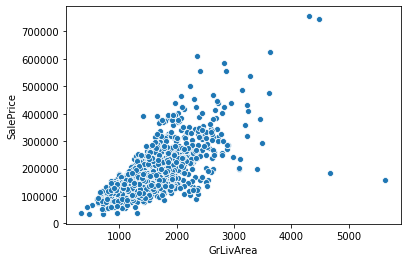

In [48]:
sns.scatterplot(x = train['GrLivArea'], y = train['SalePrice'])

Se puede apreciar en la esquina inferior derecha dos datos que indican un **AreaHabitable** muy grande, y sin embargo registran un bajo precio. Estos valores se consideran outliers. Por ello procederemos a eliminarlos.

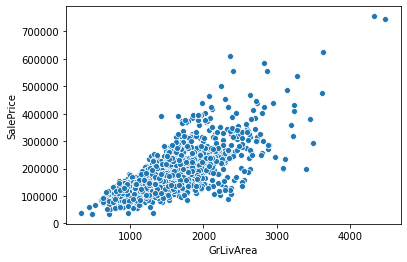

In [49]:
#Eliminamos los outliers acorde a las variables del gráfico
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Verificamos el gráfico nuevamente para confirmar que los outliers hayan sido eliminados
sns.scatterplot(x = train['GrLivArea'], y = train['SalePrice'])

##**Preprocesamiento de las variables o Feature Engineering**

**Transformando algunas variables númericas que realmente son categóricas**

In [0]:
train['YrSold'] = train['YrSold'].astype(object)
train['MoSold'] = train['MoSold'].astype(object)

**Añadimos una variable importante**

Debido a que el área total es importante para predecir el precio de la casa, sumamos las tres variables **TotalSótano, 1erPiso, 2doPiso**

In [0]:
#Añadiendo tamaño total del area
train['TotalArea'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

**Encodeamos rápidamente las variables categóricas**

In [0]:
cat_variables = [col for col in train.columns if train[col].dtype == 'object']

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for cat in cat_variables:
    le.fit(list(train[cat].values)+list(test[cat].values))
    train[cat] = le.transform(train[cat])
    test[cat] = le.transform(test[cat])

##Preprocesamiento de distribuciones que se alejan de la distribución normal

**Precio** es la variable que vamos a predecir. Asi que vamos a hacer un poco de analisis en esta variable primero.

In [0]:
from scipy.stats import norm
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Distribución del Precio')

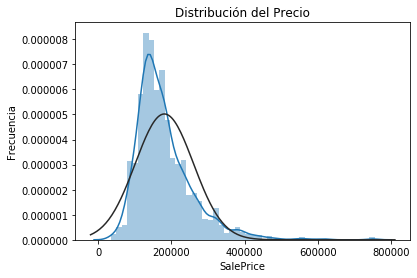

In [55]:
## Comparemos la distribución de Precio con una distribucion normal.
sns.distplot(train['SalePrice'], fit = norm)
plt.ylabel('Frecuencia')
plt.title('Distribución del Precio')

Se puede apreciar que los datos de la variable objetivo están inclinados a la izquierda. Sin embargo, los modelos lineales que veremos en la presente clase pueden optimizar su predición con datos distribuidos normalmente. Vamos a transformar los datos de esta variable para **aproximarlos a una distribución normal**.

 **Log-transformación de la variable objetivo**

Text(0.5, 1.0, 'Distribución del Precio Real Ajustado')

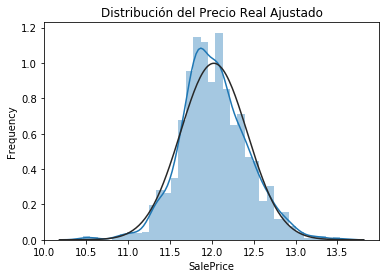

In [56]:
#Utilizamos la función log1p de la librería numpy que aplica la función log(1+x) a todos los elementos de la variable Precio
import numpy as np
train["SalePrice"] = np.log1p(train["SalePrice"])

#Dibujamos la distribución actualizada de la variable Precio
sns.distplot(train['SalePrice'] , fit=norm);

plt.ylabel('Frequency')
plt.title('Distribución del Precio Real Ajustado')

**Detectamos el grado de asimetría de las variables predictoras** - Solo aquellas con data numérica

In [0]:
from scipy.stats import skew

In [58]:
#Filtramos aquellas variables que tengan datos diferentes al tipo object, es decir numéricas
numeric_feats = train.dtypes[train.dtypes != "object"].index

#Aplicamos la función skew a las variables filtradas y mostramos el resultado ordenando de forma ascendente
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSesgo en características numéricas: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Sesgo en características numéricas: 



,Skew
Utilities,38.144471
MiscVal,24.434913
PoolArea,15.932532
Condition2,13.676313
LotArea,12.560986
3SsnPorch,10.286510
Heating,9.838030
LowQualFinSF,8.995688
RoofMatl,8.122579
Alley,5.708757


**Transformación Box Cox**

Usamos la transformación BoxCox de la librería scipy

In [0]:
skewness = skewness[abs(skewness) > 5.0]

from scipy.special import boxcox1p
skewed_features = skewness.index
for feat in skewed_features:
  train[feat] = boxcox1p(train[feat], 0.15)

Verificamos que efectivamente el sesgo de las variables (**skew**) ha disminuido

In [60]:
skew(train['MiscVal'].dropna())

5.501393371359319

# **Modelamiento**

En esta sesión utilizamos **modelos de regresión** porque vamos a predecir un **número**: precio de venta de una casa

Los modelos que ejecutaremos serán:

1.   Regresión Lasso
2.   Regresión Riedge
2.   Regresión ElasticNet

##Dividiendo la base de train en x_train, y_train

1.   La variable objetivo (**target**) es la columna **SalePrice** y la almacenamos en y
2.   Las variables predictoras las almacenamos en x_train

In [0]:
y_train = train['SalePrice'].values
x_train = train.drop(['SalePrice'], axis=1, inplace=True)

##Modelos Base

-  **Regresión Lasso**  : 

Este modelo es muy sensible a outliers, por ello necesitamos hacer más robusto el modelo a través del parámetro **Robustscaler** dentro de un pipeline

In [0]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

In [0]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- **Regresión ElasticNet** :

Nuevamente ingresamos el parámetro **Robustscaler** dentro del pipeline para hacer más robusto el modelo

In [0]:
from sklearn.linear_model import ElasticNet

In [0]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=1))

- **Regresión Kernel Ridge** :

In [0]:
from sklearn.kernel_ridge import KernelRidge

In [0]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

**Definir una estrategia de validación cruzada para optimizar los parámetros ingresados**

Usamos la función **cross_val_score** de la librería scikit-learn.
Para aleatorizar la validación previamente creamos una variable **kf**

In [0]:
from sklearn.model_selection import KFold, cross_val_score

In [0]:
#Predefinimos la variables n_folds con valor 5
n_folds = 5

#Creamos la función rmsle_cv para aplicar cross_val_score
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=1).get_n_splits(x_train.values)
    rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# Evaluación de los Modelos Base

In [70]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

AttributeError: ignored

In [0]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [0]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))